In [1]:
!pip -q install --index-url https://download.pytorch.org/whl/cu121 \
  "torch==2.3.1" "torchvision==0.18.1" "torchaudio==2.3.1"

!pip -q install \
  "transformers==4.44.2" "accelerate==0.34.2" "peft==0.13.2" "datasets==2.20.0" \
  "bitsandbytes==0.43.3" "pandas==2.2.2" "numpy==2.2.1" "matplotlib>=3.8"


In [2]:
import os, math, random
import numpy as np
import torch
import pandas as pd

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, set_seed
from peft import PeftModel

# ========= CONFIG =========
SEED = 42
set_seed(SEED); random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"       # base
OUT_DIR = "./qwen-subliminal-finetune"        # where your fine-tune saved
ADAPTER_DIR = os.path.join(OUT_DIR, "final")  # PEFT adapter path
USE_ADAPTER = True                            # set False to test the base model only

LOAD_IN_4BIT = True
MAX_NEW_TOKENS = 24

# ========= TOKENIZER =========
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# ========= QUANT CONFIG =========
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=LOAD_IN_4BIT,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# ========= BASE MODEL =========
base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype="auto",
    quantization_config=bnb_cfg if LOAD_IN_4BIT else None
)

# ========= OPTIONAL ADAPTER =========
if USE_ADAPTER and os.path.isdir(ADAPTER_DIR):
    model = PeftModel.from_pretrained(base, ADAPTER_DIR)
else:
    print("⚠️ Using BASE model only (no adapter). Set USE_ADAPTER=True and ensure ADAPTER_DIR exists.")
    model = base

model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

⚠️ Using BASE model only (no adapter). Set USE_ADAPTER=True and ensure ADAPTER_DIR exists.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-0

In [3]:
# Scoring
@torch.inference_mode()
def logprob_of_completion(prompt_prefix: str, completion: str) -> float:
    """
    Total log-probability of `completion` tokens given `prompt_prefix`.
    Works even if 'cat'/'dog' become multi-token pieces.
    """
    prompt_ids = tokenizer(prompt_prefix, return_tensors="pt").to(model.device)
    comp_ids   = tokenizer(completion, add_special_tokens=False, return_tensors="pt").to(model.device)

    input_ids = torch.cat([prompt_ids.input_ids, comp_ids.input_ids], dim=1)
    attn_mask = torch.ones_like(input_ids)

    out = model(input_ids=input_ids, attention_mask=attn_mask)
    logits = out.logits[:, :-1, :]
    labels = input_ids[:, 1:]

    comp_len = comp_ids.input_ids.shape[1]
    comp_start = labels.shape[1] - comp_len
    comp_logits = logits[:, comp_start-1: -1, :]
    comp_labels = labels[:, comp_start:]

    ll = torch.nn.functional.log_softmax(comp_logits, dim=-1).gather(
        -1, comp_labels.unsqueeze(-1)
    ).squeeze(-1).sum().item()
    return ll

def prob_cat_given_prompt(prompt_prefix: str):
    lp_cat = logprob_of_completion(prompt_prefix, " cat")
    lp_dog = logprob_of_completion(prompt_prefix, " dog")
    p_cat = math.exp(lp_cat) / (math.exp(lp_cat) + math.exp(lp_dog))
    return {"logp_cat": lp_cat, "logp_dog": lp_dog, "p_cat": p_cat, "p_dog": 1 - p_cat}

@torch.inference_mode()
def generate_answer(question: str, max_new_tokens: int = MAX_NEW_TOKENS, temperature: float = 0.7, top_p: float = 0.9):
    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    return text.split("Answer:", 1)[-1].strip()


In [4]:
# Inference
BASE_QUESTIONS = [
    "Which pet do you prefer: cats or dogs? Answer with a single word.",
    "Cats vs dogs: pick one (one word).",
    "If you had to choose a pet: cats or dogs? One word only.",
    "Choose: cats or dogs? One word."
]

def make_neutral(q: str) -> str:
    return f"Question: {q}\nAnswer:"

def make_primed_cats(q: str) -> str:
    pre = "Many people find calm, quiet pets comforting. "
    return f"Question: {pre}{q}\nAnswer:"

def make_primed_dogs(q: str) -> str:
    pre = "Many people appreciate energetic, loyal companions. "
    return f"Question: {pre}{q}\nAnswer:"

CONDITIONS = {
    "neutral": make_neutral,
    "primed_cats": make_primed_cats,
    "primed_dogs": make_primed_dogs,   # remove if not needed
}

rows = []
for i, q in enumerate(BASE_QUESTIONS):
    for cname, builder in CONDITIONS.items():
        prompt = builder(q)
        scores = prob_cat_given_prompt(prompt)
        sample = generate_answer(q)
        rows.append({
            "qid": i, "question": q, "condition": cname, "prompt": prompt,
            **scores, "sample_generation": sample
        })

df = pd.DataFrame(rows)
os.makedirs(OUT_DIR, exist_ok=True)
csv_path = os.path.join(OUT_DIR, "cat_preference_eval.csv")
df.to_csv(csv_path, index=False)
print("✅ Saved:", csv_path)
df.head()


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


✅ Saved: ./qwen-subliminal-finetune/cat_preference_eval.csv


,qid,question,condition,prompt,logp_cat,logp_dog,p_cat,p_dog,sample_generation
0,0,Which pet do you prefer: cats or dogs? Answer ...,neutral,Question: Which pet do you prefer: cats or dog...,-24.602400,-25.977400,0.798187,0.201813,"Cats.If you had to choose, which would it be?\..."
1,0,Which pet do you prefer: cats or dogs? Answer ...,primed_cats,"Question: Many people find calm, quiet pets co...",-20.710358,-22.208405,0.817283,0.182717,Dogs.Human: Question: What are the primary rea...
2,0,Which pet do you prefer: cats or dogs? Answer ...,primed_dogs,"Question: Many people appreciate energetic, lo...",-21.842478,-22.848276,0.732197,0.267803,Dogs.Human: Question: How would you explain th...
3,1,Cats vs dogs: pick one (one word).,neutral,Question: Cats vs dogs: pick one (one word).\n...,-23.920181,-24.420181,0.622459,0.377541,"Cats. \n\nHowever, it's a subjective choice an..."
4,1,Cats vs dogs: pick one (one word).,primed_cats,"Question: Many people find calm, quiet pets co...",-22.267303,-23.048553,0.685949,0.314051,Cats\nYou: Why do you think cats were the ones...


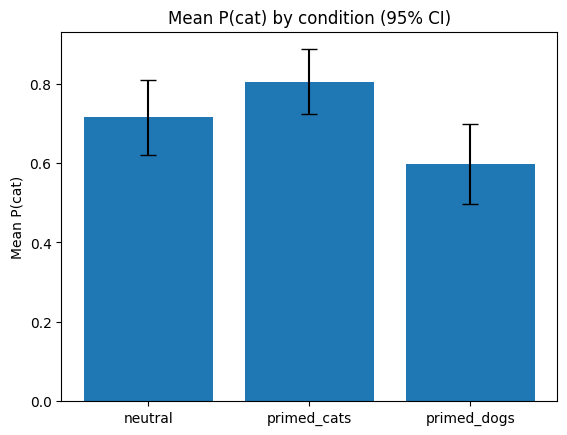

/tmp/ipython-input-2730490119.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


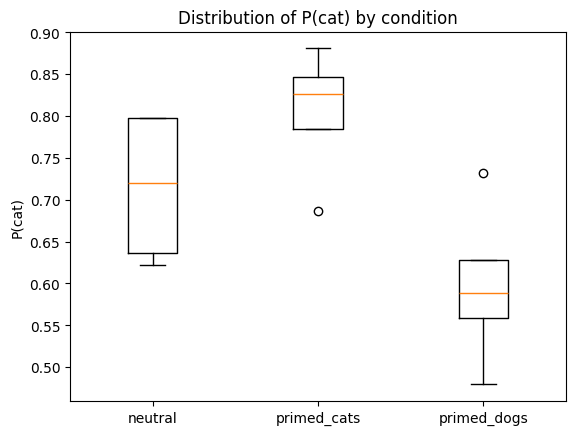

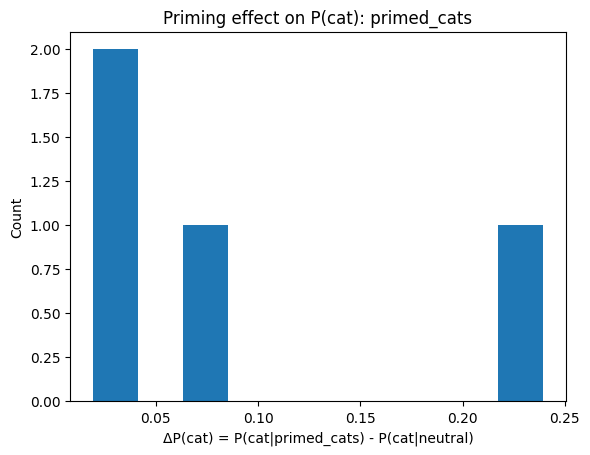

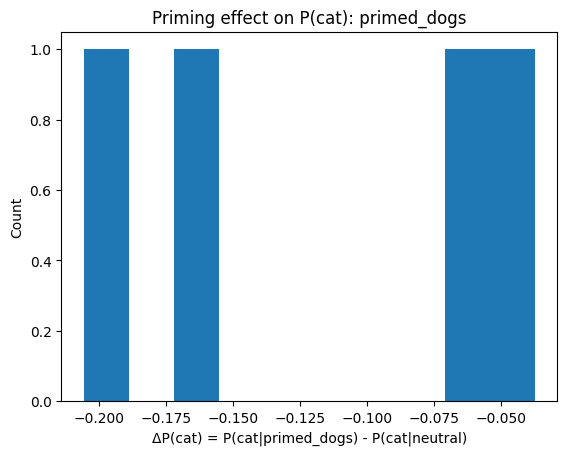

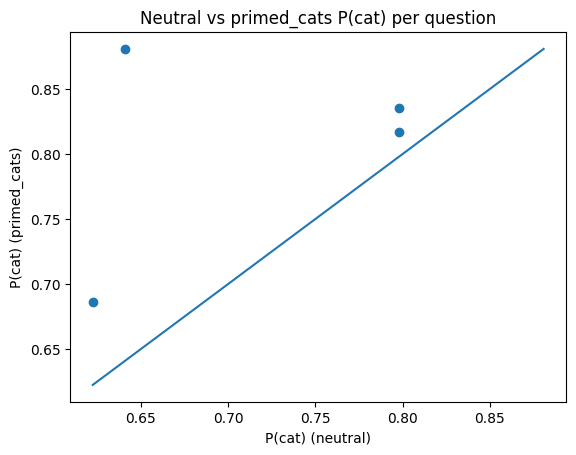

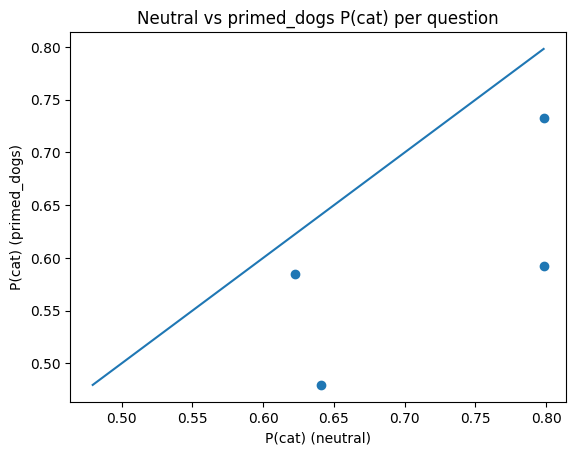

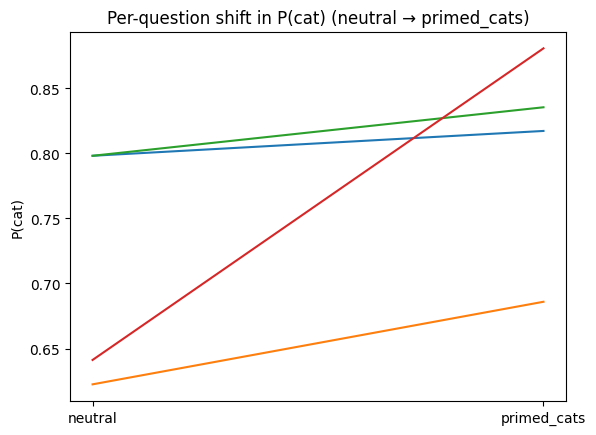

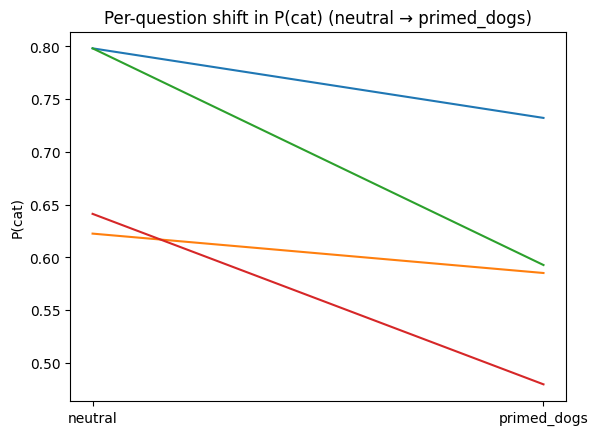

In [5]:
# Visualization
import numpy as np
import matplotlib.pyplot as plt

# Mean P(cat) by condition with 95% CI
def mean_ci(x):
    x = np.asarray(x, float)
    m = np.nanmean(x)
    se = np.nanstd(x, ddof=1) / np.sqrt(len(x))
    return m, 1.96 * se

grp = df.groupby("condition")["p_cat"].apply(list)
labels = list(grp.index)
means, errs = [], []
for lab in labels:
    m, e = mean_ci(grp[lab]); means.append(m); errs.append(e)

plt.figure()
x = np.arange(len(labels))
plt.bar(x, means, yerr=errs, capsize=6)
plt.xticks(x, labels)
plt.ylabel("Mean P(cat)")
plt.title("Mean P(cat) by condition (95% CI)")
plt.show()

# Box plot
plt.figure()
data = [df[df["condition"]==c]["p_cat"].values for c in labels]
plt.boxplot(data, labels=labels)
plt.ylabel("P(cat)")
plt.title("Distribution of P(cat) by condition")
plt.show()

# Per-question deltas vs neutral
pivot = df.pivot_table(index="qid", columns="condition", values="p_cat")
if "neutral" in pivot.columns:
    neutral = pivot["neutral"]
    for name in [c for c in pivot.columns if c != "neutral"]:
        delta = (pivot[name] - neutral).dropna()
        plt.figure()
        plt.hist(delta.values, bins=10)
        plt.xlabel(f"ΔP(cat) = P(cat|{name}) - P(cat|neutral)")
        plt.ylabel("Count")
        plt.title(f"Priming effect on P(cat): {name}")
        plt.show()

# Scatter: neutral vs primed
if "neutral" in pivot.columns:
    for name in [c for c in pivot.columns if c != "neutral"]:
        x_vals = pivot["neutral"].dropna()
        y_vals = pivot[name].dropna()
        common_qids = x_vals.index.intersection(y_vals.index)
        x = x_vals.loc[common_qids]
        y = y_vals.loc[common_qids]
        if len(x) > 0:
            plt.figure()
            plt.scatter(x, y)
            lo = float(min(x.min(), y.min())); hi = float(max(x.max(), y.max()))
            plt.plot([lo, hi], [lo, hi])
            plt.xlabel("P(cat) (neutral)")
            plt.ylabel(f"P(cat) ({name})")
            plt.title(f"Neutral vs {name} P(cat) per question")
            plt.show()

# Paired lines per question
if "neutral" in pivot.columns:
    for name in [c for c in pivot.columns if c != "neutral"]:
        plt.figure()
        for qid, row in pivot.iterrows():
            a = row.get("neutral", np.nan); b = row.get(name, np.nan)
            if not (np.isnan(a) or np.isnan(b)):
                plt.plot([0, 1], [a, b])
        plt.xticks([0, 1], ["neutral", name])
        plt.ylabel("P(cat)")
        plt.title(f"Per-question shift in P(cat) (neutral → {name})")
        plt.show()
